# Neural Network Approximation
## Introduction
Deep Neural Networks have achieved remarkable performance in various areas of artificial intelligence. Despite these experimental successes, the theoretical understanding of deep learning remains elusive. One of the most significant theoretical aspects of deep neural networks is their ability to approximate functions.

In the first part of this project, we focus on the problem of optimal approximation: Given a continuous function and the maximum number of linear segments generated by a ReLU neural network, what is the smallest possible approximation error? This optimal approximation problem holds fundamental theoretical importance as it determines the best achievable approximation level and may have practical implications for other deep learning problems.

The story unfolds gradually, starting from the necessary and sufficient conditions for achieving optimal approximation using piecewise linear functions, moving to theoretical approximation bounds, followed by our ReLU network architecture to generate the desired optimal approximations, including a discussion on its scalability for approximation in a higher-dimensional space, and concluding with an optimization algorithm to find the optimal approximation. Each chapter includes both theoretical discussions and practical implementations when necessary.

In the second part of this project, we explore an different approximation strategy based on the Growing Axon architecture, and compare its performance with that of traditional ReLU networks. This method incrementally adds one neuron at each step, similar to the orthogonal matching pursuit (OMP) approach in compressed sensing. At each substep, we only need to solve a relatively simple optimization problem. The performance of this method will be illustrated and directly compared to the traditional approach.

This study is largely inspired by the work of Bo Liu and Yi Liang **[1]**, Fokina, Daria and Oseledets, Ivan **[2]**, and the accompanying implementation **[3]**, which offers clear insights into optimal function approximation with ReLU neural networks from both theoretical and constructive perspectives.

## Chapter 1: Necessary and Sufficient Conditions for Optimal Approximation
In this section, we lay out the fundamental assumptions and conditions required for function approximation using neural networks. These include conditions on continuity, differentiability, and other topological properties of the function space. Rather than introducing all computational functions upfront, we explain each function when it is required for a specific result or proof.

In [1]:
cd ../..

d:\nna_24-25_pham


In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from data.generators import *
from utils.trainer import train_model
from utils.evaluator import evaluate_model
from utils.visualizer import *
from utils.maths import *
from utils.algo import *
from model.simple_model import FFN_Network
from typing import Callable
from tqdm.auto import tqdm
import numpy as np
import nevergrad as ng
from model.axon_approximation import axon_algorithm, AxonModel_np
import matplotlib.pyplot as plt
import pickle
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore")

mpl.rcParams['text.usetex'] = False
plt.rc('font', size=14)

d:\nna_24-25_pham\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Motivation and Preliminary Experiments

When I first came across the paper  **[1]**, I noticed that the core idea of the problem closely resembles a standard regression task. This led me to wonder: Could a simple Feedforward Neural Network (FFN), typically used in regression, be applied to approximate a general function? To explore this hypothesis, I built a basic deep network to test its approximation capability - serving both as a preliminary experiment and as a motivation to later explore more theoretically grounded, optimal methods.

In [4]:
FUNCTION = lambda x: x**2
A, B = 0, 4

In [5]:
X_train, X_val, y_train, y_val = generate_1d_convex(n_samples=1024, interval=(A, B), func=FUNCTION)
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [6]:
model = FFN_Network(input_dim=1, hidden_layers=2, hidden_units=8, output_dim=1)
history = train_model(model, train_loader, val_loader, epochs=32, lr=0.01, device=device)

Training Configurations:
Device: cpu
Epochs: 32
Learning Rate: 0.01



Training: 100%|██████████| 32/32 [00:00<00:00, 33.33epoch/s]


In [7]:
test_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
y_pred, y_actual = evaluate_model(model, test_loader, device=device)

Evaluation Configurations:
Device: cpu



Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1749.81batch/s]


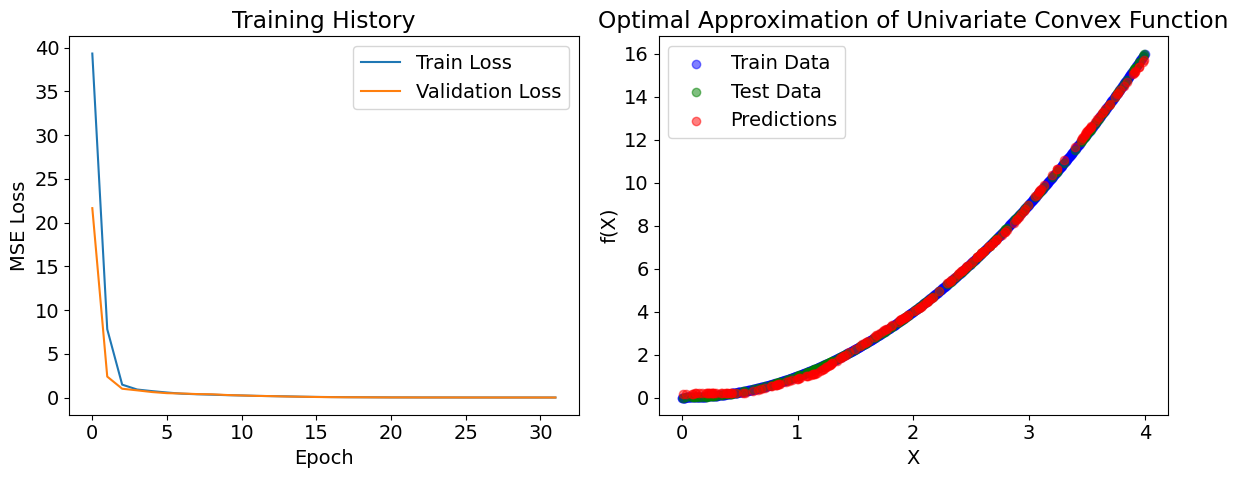

In [8]:
plot_results_1d(
    X_train, y_train, X_val, y_val, y_pred,
    history,
    title='Optimal Approximation of Univariate Convex Function'
)

The initial results demonstrate that the model can effectively approximate simple convex functions, such as $f(x) = x^2$ within a bounded domain.

This naturally leads to the question of whether the same model can generalize to more complex functions or operate accurately over extended input domains?

In [9]:
FUNCTION = lambda x: x**10 + np.exp(np.sqrt(x))
A, B = 0, 10    

In [10]:
X_train, X_val, y_train, y_val = generate_1d_convex(n_samples=1024, interval=(A, B), func=FUNCTION)
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [11]:
model = FFN_Network(input_dim = 1,
                     hidden_layers = 4, # note that the number of hidden layers is increased
                     hidden_units = 10, # and so is the number of hidden units
                     output_dim = 1)
history = train_model(model, train_loader, val_loader, epochs=32, lr=0.01, device=device)

Training Configurations:
Device: cpu
Epochs: 32
Learning Rate: 0.01



Training: 100%|██████████| 32/32 [00:01<00:00, 24.94epoch/s]


In [12]:
test_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
y_pred, y_actual = evaluate_model(model, test_loader, device=device)

Evaluation Configurations:
Device: cpu



Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1748.56batch/s]


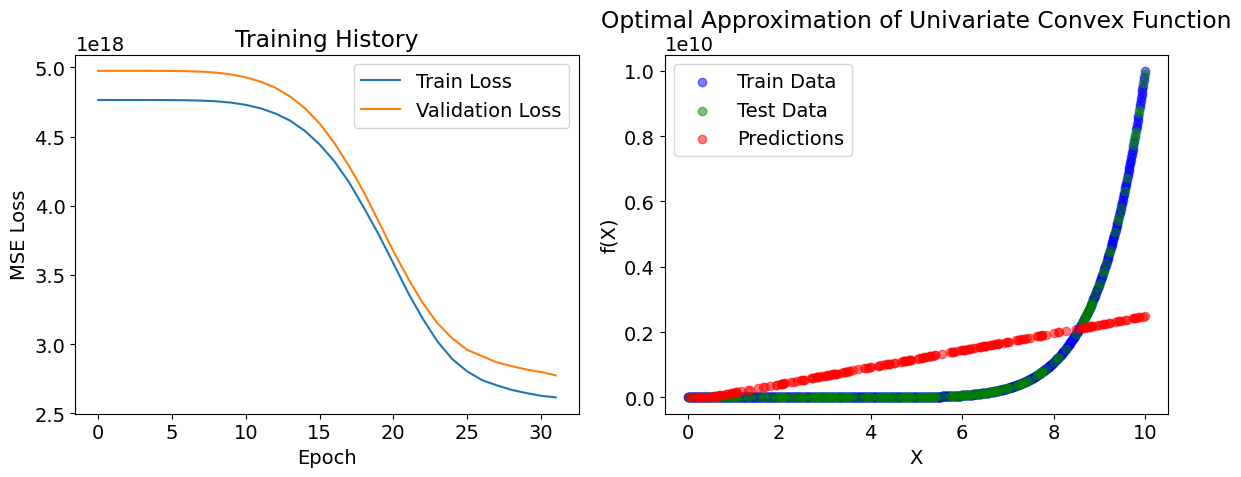

In [13]:
plot_results_1d(
    X_train, y_train, X_val, y_val, y_pred,
    history,
    title='Optimal Approximation of Univariate Convex Function'
)

The results reveal that the model fails to accurately approximate the target function across the domain, especially in regions with steep gradients. This indicates a significant limitation of the current network configuration when applied to more complex functions.

Even though we increased the depth and width of the network, the approximation is still far from the true function. This highlights a real-world challenge, which is **deep networks are not magic**, especially when dealing with highly nonlinear or steep convex functions. The low MSE Loss shows that the model is doing its best to approximate the function (potentially overfitting), but the approximation is still not satisfactory.

In many practical situations, we do not have perfect access to high-resolution data or unlimited model capacity. In fact, we may have to deal with **noisy**, **incomplete**, or **low-resolution** data. Sometimes, data is only provided at a **few discrete points**, or even displayed visually as an **image** which needs to be processed.

This is why understanding the **limitations** of neural network approximators is crucial - both from a **theoretical** and **practical** standpoint.

---

To overcome these challenges, we now explore an alternative approach based on **optimal piecewise linear approximation**.

### Problem Setup and Notation

Let $f(x)$ be a univariate convex function defined on an interval $[a, b]$.  
We approximate $f(x)$ using a piecewise linear function $f_n(x)$ with $n$ linear segments, and measure the approximation error in the uniform norm $ \| \cdot \|_{\infty} $:

$$
\Delta(f_n^*) \triangleq \inf_{f_n} \max_{x \in [a, b]} |f(x) - f_n(x)|
$$

where $f_n^* (x)$ is the optimal piecewise linear function with $n$ segments.


We partition $[a, b]$ into $n$ sub-intervals $[a_i, b_i], i=1,2,...,n$, and in each $[a_i, b_i]$, $f_n (x)$ is single linear piece which we denote as $S_i$.  
The approximation error of a single segment is defined as:
$$
\Delta(S_i) \triangleq \max_{x \in [a_i, b_i]} |f(x) - S_i(x)|
$$

The optimal linear segment over $[a_i, b_i]$ is denoted by $S_i^*$, with:
$$
\Delta(S_i^*) \triangleq \inf_{S_i} \Delta(S_i)
$$

---

To build some intuition, we will return to a **simpler function**. Let's consider:

$$
f(x) = x^2, \quad \text{for } x \in [0, 1]
$$

This function is:
- Convex
- Smooth
- Continuous

In [14]:
FUNCTION = lambda x: x**2
A, B = 0, 1

By reproducing the maths in the research paper, we can compute the theoretical approximation error.

In [15]:
error = compute_approximation_error(f=FUNCTION, interval=(A, B))
error["error"]

0.125

### Theoretical Justification of the Approximation Error

The value $\Delta(S^*) = 0.125$ can be explained explicitly using $\textbf{Lemma 1}$ from **[1]**.

$\textbf{Lemma 1}$ (optimal approximation by a single segment). For functions $f(x) \in C^2[a,b]$ with $f''(x) > 0$ ( $a \leq x \leq b$ ), the optimal approximation error by a line segment $S(x)$ is

$$
 \Delta(S^*) = \dfrac{c - a}{2} \left[ f'(c) - f'(d) \right] 
$$

where $c$ is determined by

$$ 
f'(c) = \dfrac{f(b) - f(a)}{b - a}
$$

and $d$ is determined similarly by

$$ 
f'(d) = \dfrac{f(c) - f(a)}{c - a} 
$$

---

#### Now, we have:
1. The function is $f(x) = x^2$, defined over the interval $[0, 1]$.
2. The derivative of the function is $f'(x) = 2x$.

We aim to calculate the **optimal approximation error** $\Delta(S^*)$ for the function $f(x) = x^2$ over the interval $[0, 1]$.

---

#### Step 1: Compute $c$

From the formula for $c$:

$$
f'(c) = \frac{f(b) - f(a)}{b-a}
$$

Substitute the values:
- $f(b) = 1^2 = 1$
- $f(a) = 0$
- $b - a = 1 - 0 = 1$

Thus:

$$
f'(c) = \frac{1 - 0}{1} = 1
$$

Since $f'(x) = 2x$, we have:

$$
2c = 1 \quad \Rightarrow \quad c = 0.5
$$

---

#### Step 2: Compute $d$

From the formula for $d$:

$$
f'(d) = \frac{f(c) - f(a)}{c-a}
$$

Substitute the values:
- $f(c) = (0.5)^2 = 0.25$
- $f(a) = 0$
- $c - a = 0.5 - 0 = 0.5$

Thus:

$$
f'(d) = \frac{0.25 - 0}{0.5} = 0.5
$$

---

#### Step 3: Compute $\Delta(S^*)$

Using the formula for $\Delta(S^*)$:

$$
\Delta(S^*) = \frac{c-a}{2} \left[f'(c) - f'(d)\right]
$$

Substitute the values:
- $c - a = 0.5 - 0 = 0.5$
- $f'(c) = 1$
- $f'(d) = 0.5$

Thus:

$$
\Delta(S^*) = \frac{0.5}{2} \left[1 - 0.5\right]
$$

Simplify:

$$
\Delta(S^*) = \frac{0.5}{2} \cdot 0.5 = 0.125
$$

---

### Conclusion

The optimal approximation error is:

$$
\Delta(S^*) = 0.125
$$

This result is derived from the specific properties of the function $f(x) = x^2$ and the optimal conditions for piecewise linear approximation over the interval $[0, 1]$.

---


We next refer to $\textbf{Lemma 2}$ from **[1]**, which characterizes how the optimal approximation error varies with the length of the approximation interval.

$\textbf{Lemma 2}$. For convex functions $f(x)$, if one enlarges $[a, b]$ by moving the endpoint $b$ to the right, or $a$ to the left, the optimal approximation error $\Delta(S^*)$ of the function $f(x)$ by a line segment $S(x)$ will increase. On the contrary, if one reduces the interval $[a, b]$ by moving the endpoint $b$ to the left, or $a$ to the right, the optimal approximation error $\Delta(S^*)$ will decrease.

In [16]:
a, b = -1, 2 # move b to the right, and a to the left
error = compute_approximation_error(f=FUNCTION, interval=(a, b))
error = error["error"]
print(f"\nTheoretical Approximation Error: {error}, larger than 0.125 on [0, 1].")


Theoretical Approximation Error: 1.125, larger than 0.125 on [0, 1].


In [17]:
a, b = 0, 0.7 # move b to the left
error = compute_approximation_error(f=FUNCTION, interval=(a, b))
error = error["error"]
print(f"\nTheoretical Approximation Error: {error}, smaller than 0.125 on [0, 1].")


Theoretical Approximation Error: 0.06124999999999999, smaller than 0.125 on [0, 1].


$\textbf{Remark}$. Although reducing the interval $[a,b]$ leads to smaller approximation errors (as shown in Lemma 2), this does not contradict the concept of "optimal approximation error" in Lemma 1. The latter is defined with respect to a fixed domain, meaning that no better linear approximation exists on that specific interval. Changing the interval effectively defines a new approximation problem.

The comparison of approximation errors across different intervals is not aimed at minimizing error on a fixed domain, but rather to illustrate the qualitative behavior stated in Lemma 2: when the approximation interval is enlarged, the optimal error increases; conversely, when the interval is shrunk, the optimal error decreases.

### Necessary and Sufficient Conditions for Optimal Piecewise Linear Approximation

To determine the conditions under which piecewise linear approximations achieve minimal error, we refer to **Theorem 1** from **[1]**.

$\textbf{Theorem 1}$. Given a strict convex univariate function $f(x)$ and a ReLU neural network generated piecewise linear function $f_n(x)$ with $n$ linear segments to approximate $f(x)$, the necessary and sufficient conditions for $f_n(x)$ to achieve optimal approximation are:

$$
\Delta(S_1^*) = \Delta(S_2^*) = \cdots = \Delta(S_n^*) = \Delta(f_n^*) \tag{3.1}
$$

The optimal approximation is also unique.

***Proof of Theorem 1.*** 

***Necessary conditions.*** 

The main idea is to show that if the condition (3.1) does **not** hold, we can always reduce the approximation errors further. This means the original piecewise linear function is not yet optimal because there is still room for improvement. The proof constructs a process: Whenever the segment errors are imbalanced, we can adjust the boundary between adjacent segments to reduce the maximum error, eventually leading to equalized segment errors.

For a complete and rigorous proof, please refer to the original paper [1].

***Sufficient Conditions.***

Once the chain of equalities holds, any movements of interior endpoints will cause ${\Delta(f'_n)}$ to increase, and subsequent sewing neighboring segments at common endpoints to make $f_n$ be continuous will increase ${\Delta(f'_n)}$ further. Therefore, the chain of equalities below is sufficient for optimal approximation.

$$
    \Delta(S^*_1) = \Delta(S^*_2) = \Delta(S^*_3) = \cdots = \Delta(S^*_n) = \Delta(f^*_n)
$$

***Uniqueness.***

We will prove it by contradiction. 
Assume there are two different optimal piecewise linear functions with the same approximation errors. Geometrically, there must exist two intervals with one of them being included in another, such as $[a, e]$ and $[a, e_1]$ due to the fact that endpoints $a$ and $b$ are fixed. 

By the assumption that the two configurations have equal optimal approximation errors and the optimality conditions, one has 
$$
\Delta(f^*_3) = \Delta(S^*_{\substack{ae}}); \Delta(f^*_3) = \Delta(S^*_{\substack{ae_1}}) \quad \tag{3.15}
$$
However, $[a, e]$ and $[a, e_1]$ have different lengths, by Lemma 2 which claims the monotony of optimal approximation error with respect to interval length, we have
$$
\Delta(S^*_{\substack{ae}}) \neq \Delta(S^*_{\substack{ae_1}}),
$$
which contradicts $(3.15)$. As a result, the optimal approximation $f^*_n(x)$ is unique.

## Chapter 2: Approximation Bounds and Convergence Rates
This chapter explores the approximation capacity and convergence rate of neural networks, with a focus on the theoretical foundations like Lemmas and Theorems that describe when and how well a neural network can approximate a given function. We discuss bounds, both upper and lower, and compare them with numerical observations when applicable.

In [18]:
FUNCTION = lambda x: x**2
A = 0
B = 1

In [19]:
error = compute_approximation_error(f = FUNCTION, interval=(A,B))
error["error"]

0.125

### Explanation for the error $\Delta(S^*)$
The explanation for the error $\Delta(S^*)$ being $0.125$ is provided above. Readers are encouraged to refer to that for a detailed explanation.

In [20]:
assert error['c'] == (B+A)/2
print("c is the midpoint of the interval [a, b], as expected.")

assert error['d'] == (error['c'] + A)/2
print("d is the midpoint between c and a, as expected.")

c is the midpoint of the interval [a, b], as expected.
d is the midpoint between c and a, as expected.



We observe that for convex functions with constant second-order derivatives, such as $f(x) = x^2$, the value of $c$ defined by the condition
$$
f'(c) = \dfrac{f(b) - f(a)}{b - a}
$$
is located at the midpoint of the interval $[a, b]$. Similarly, the point $d$, defined via

$$
f'(d) = \dfrac{f(c) - f(a)}{c - a}
$$
lies at the midpoint of $[a, c]$.

This is precisely what **Lemma 3** from **[1]** states.

***Proof.***

The second derivative of the function $f(x) = x^2$ is equal to 2, so it is constant.
Mathematically, this can be expressed as:
$$
f''(x) = 	constant
$$

For a quadratic function, $f(x)$ can be written in terms of its second derivative as:
$$
f(x) = [0.5 \cdot f''(x)] \cdot x^2 + k \cdot x + e,
$$
where $k$ and $e$ are constants.

The derivative at the midpoint $c$ can be calculated as:
$$
f'(c) = \frac{f(b) - f(a)}{b - a}.
$$

Substituting the values of $f(b)$ and $f(a)$ into the equation:
$$
f'(c) = \frac{\left( \frac{f'' \cdot b^2}{2} + k \cdot b \right) - \left( \frac{f'' \cdot a^2}{2} + k \cdot a \right)}{b - a}.
$$

Simplifying further:
$$
f'(c) = \frac{f'' \cdot (b-a) \cdot (b+a)}{2(b-a)} + k.
$$

This reduces to:
$$
f'(c) = \frac{f'' \cdot (b+a)}{2} + k = f'' \cdot c + k.
$$

This implies that $c = \frac{a+b}{2}$.

Similarly, it can be shown that $d = \frac{c+a}{2}$ is the midpoint between $c$ and $a$, providing further approximation points.

### Approximation error bounds

We now give our upper and lower bounds of optimal approximation error through $\textbf{Theorem 2}$ from **[1]**.

$\textbf{Theorem 2}$. The optimal approximate error $\Delta(f_n^*)$ is bounded as

$$
\frac{(b-a)^2}{16 \cdot n^2} \cdot \min_{x \in [a,b]} f''(x)
\;\leq\;
\Delta(f_n^*)
\;\leq\;
\frac{(b-a)^2}{16 \cdot n^2} \cdot \max_{x \in [a,b]} f''(x)
$$

***Proof.*** 

***Upper Bound.***

For any convex function $f(x)$, we construct a function $\bar{f}(x)$ which has a constant second-order derivative $\bar{f}''(x) = \max_{x \in [a,b]} f''(x)$, i.e., $\bar{f}(x)$ is constructed using the most convex point of $f(x)$.

Since $\bar{f}(x)$ is more convex than $f(x)$, when using piecewise linear functions with $n$ segments to approximate them, $\Delta(f_n^*)$ will be upper bounded by the optimal approximation error $\Delta(\bar{f}_n^*)$ of function $\bar{f}(x)$. It implies:
$$
\Delta(f_n^*) = \Delta(S_i^*) \leq \Delta(\bar{f}_n^*) = \Delta(\bar{S}_i^*) = \frac{c_i - a_i}{2} \cdot \left[ \bar{f}'(c_i) - \bar{f}'(d_i) \right]
$$

where $c_i$ and $d_i$ are determined by function $\bar{f}(x)$, lie at the midpoint of each segment $[a_i, b_i]$, $[a_i, c_i]$ respectively by ***Lemma 3***. Mathematically:
$$
c_i - a_i = \frac{b_i - a_i}{2}, \quad d_i - a_i = \frac{c_i - a_i}{2} = \frac{b_i - a_i}{4}.
$$

Substituting these values, we have:
$$
\Delta(f_n^*) \leq \frac{c_i - a_i}{2} \cdot \bar{f}'' \cdot [c_i - d_i] = \frac{b_i - a_i}{4} \max_{x \in [a,b]} f''(x) \left[ \frac{b_i - a_i}{2} - \frac{b_i - a_i}{4} \right]
= \frac{(b_i - a_i)^2}{16} \max_{x \in [a,b]} f''(x)
$$

Consider the segment corresponding to the shortest interval for which we have $b_i - a_i \leq \frac{b-a}{n}$, thereby we get the following upper bound,
$$
\Delta(f_n^*) \leq \frac{(b-a)^2}{16 \cdot n^2} \cdot \max_{x \in [a,b]} f''(x).
$$

***Lower Bound.***

In exactly the same way as we derived the upper bound, we obtain the lower bound:
$$
\Delta(f_n^*) \geq \frac{(b-a)^2}{16 \cdot n^2} \cdot \min_{x \in [a,b]} f''(x).
$$

***Final Result.***

Combining both bounds, we conclude:
$$
\frac{(b-a)^2}{16 \cdot n^2} \cdot \min_{x \in [a,b]} f''(x) \leq \Delta(f_n^*) \leq \frac{(b-a)^2}{16 \cdot n^2} \cdot \max_{x \in [a,b]} f''(x).
$$


This completes the proof of Theorem 2.

### Convergence Rate
The convergence rate of the error $\Delta(f_n^*)$ is $\mathcal{O}(n^{-2})$. This implies that the error decreases quadratically with the number of segments $n$.

Since $b-a$ is irrelevant to the convergence rate while being the interval length, the error is independent of the interval length. Meanwhile, minimal and maximal second derivatives are crucial for the error bounds, also not affecting the convergence rate.

Therefore, the error $\Delta(f_n^*)$ is independent of the interval length and converges quadratically with the number of segments $n$. In other words, the Convergence Rate is $\mathcal{O}(n^{-2})$.

## Chapter 3: ReLU Network and Piecewise Linear Regression
In this chapter, we examine a ReLU-based regression network as a case study of function approximation.

#### Limitations of Regression Networks
While regression networks are commonly used for function approximation, several key weaknesses have been identified in **[4]** and **[5]**:
- **High Complexity**: These networks often require a large number of neurons or layers to approximate complex nonlinear functions accurately. This leads to increased computational costs.
- **Generalization Issues**: Regression networks trained on specific data ranges may perform poorly on unseen data, particularly when the function has high variation.
- **Local Approximation**: Due to their piecewise linear nature, ReLU networks may approximate well only in local regions and fail to capture global behaviors.

#### Example Limitations
- For instance, approximating a sinusoidal function using ReLU-based networks would require many linear pieces to mimic the curvature, resulting in overparameterization.
- Moreover, such networks may overfit specific patterns (e.g., periodicity in the training range), resulting in poor extrapolation to unseen inputs.


These limitations motivate the need for improved architectures that can balance expressiveness with efficiency - a key direction in ongoing scientific research.

In the following sections, given the optimal piecewise linear approximation $f_n^*(x)$, we present ReLU-based network architectures that are explicitly constructed to generate each linear segment of $f_n^*(x)$. The segments are produced one by one, providing a principled solution to the overparameterization issues observed in conventional designs.

### Import Models
Import the `ReluSegmentNetwork`, `FixedWidthReluNetwork` and `ReluSegmentNetwork2D` models from the `model.piecewise_linear_fn` modules

In [21]:
from model.piecewise_linear_fn import ReluSegmentNetwork, FixedWidthReluNetwork, ReluSegmentNetwork2D

### Fixed-Depth ReLU Network

#### Define and Plot Data Points
- Defines `x_points` and `y_points`, which represent the breakpoints and values of a piecewise linear function.
- Visualizes these data points using a scatter plot.

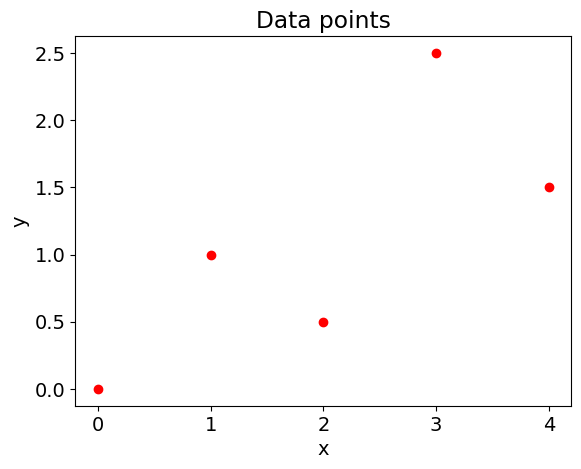

In [22]:
x_points = [0, 1, 2, 3, 4]
y_points = [0, 1, 0.5, 2.5, 1.5]

# plot
plt.plot(x_points, y_points, 'ro')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data points')
plt.show()

#### Initialize `ReluSegmentNetwork`
- Instantiates the `ReluSegmentNetwork` model using the defined `x_points` and `y_points`.

In [23]:
model = ReluSegmentNetwork(
    x_points=x_points,
    y_points=y_points
)

In [24]:
print(model(2))

tensor(0.5000)


#### Generate Function Values for `ReluSegmentNetwork`
- Defines a range of `x` values for evaluating the model.

- Uses the model to compute:
  - Base value $f_n^*(x_1)$,
  - Outputs of individual segments ($O_i$).

- Calculates the reconstructed piecewise linear function ($f_x$) by summing these components.
- Computes the original piecewise linear function using a mask for comparison.

In [25]:
x = torch.linspace(-1, 10, 500)

with torch.no_grad():
    f_x = model(x)

#### Plot Results for `ReluSegmentNetwork`
- Creates two subplots:
  - Original piecewise linear function, connecting `x_points` and `y_points`.
  - Reconstructed function generated by `ReluSegmentNetwork`.
- Configures axes, legends, and grid for clarity.

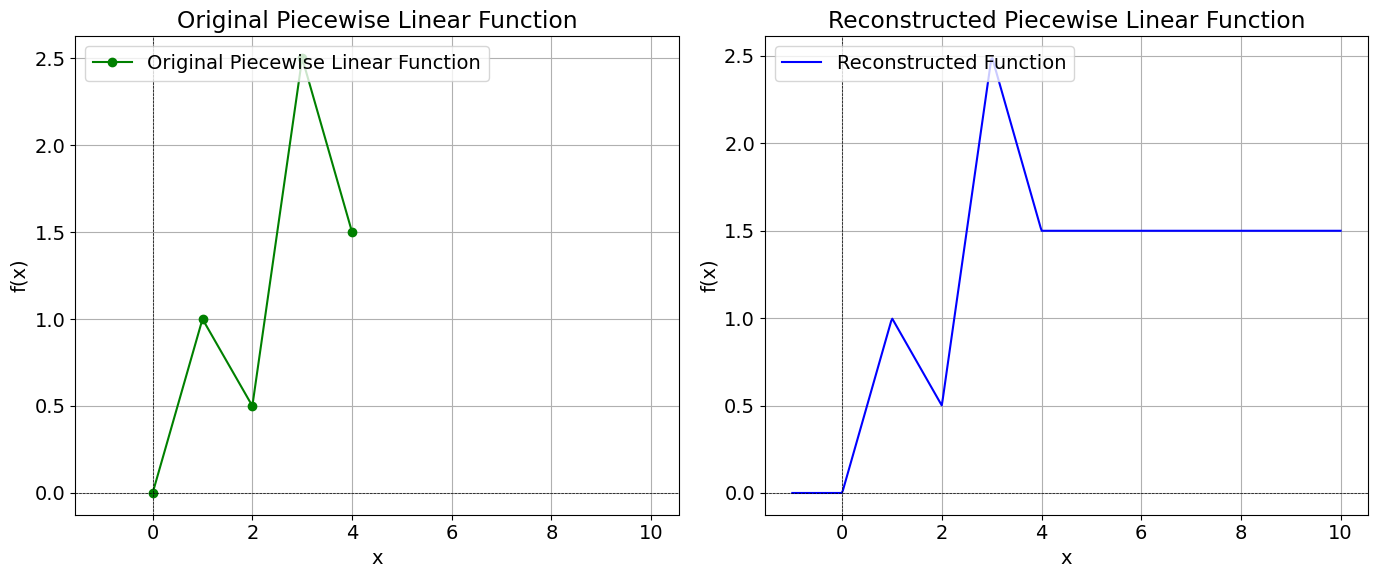

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

# Plot the original piecewise linear function by connecting the given x, y coordinates
axs[0].plot(x_points, y_points, label="Original Piecewise Linear Function", color="green", marker="o")
axs[0].set_title("Original Piecewise Linear Function")
axs[0].set_xlabel("x")
axs[0].set_ylabel("f(x)")
axs[0].axhline(0, color="black", linewidth=0.5, linestyle="--")
axs[0].axvline(0, color="black", linewidth=0.5, linestyle="--")
axs[0].legend(loc="upper left")
axs[0].grid()

# Plot the reconstructed piecewise linear function
axs[1].plot(x.numpy(), f_x.numpy(), label="Reconstructed Function", color="blue")
axs[1].set_title("Reconstructed Piecewise Linear Function")
axs[1].set_xlabel("x")
axs[1].set_ylabel("f(x)")
axs[1].axhline(0, color="black", linewidth=0.5, linestyle="--")
axs[1].axvline(0, color="black", linewidth=0.5, linestyle="--")
axs[1].legend(loc="upper left")
axs[1].grid()

plt.tight_layout()
plt.show()

The reconstructed function closely matches the original piecewise linear function, demonstrating the model's ability to approximate the function. The plot in given interval matches perfectly with the original function, while the plot outside the interval has $f(x)$ staying constant at the last value of the interval.

However, a limitation of this method is the presence of slight discontinuities in the derivative at the connecting points, leading to noticeable non-smooth transitions between linear segments. Additionally, the holding the last value constant may not reflect the actual trend of the original function outside the known interval.

### Fixed-Width ReLU Network

#### Define and Plot New Data Points
- Redefines `x_points` and `y_points` to represent a different piecewise linear function.
- Visualizes the new data points.

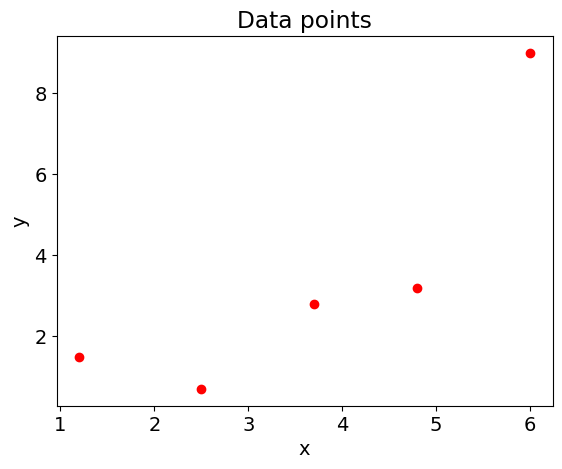

In [27]:
x_points = [1.2, 2.5, 3.7, 4.8, 6.0]
y_points = [1.5, 0.7, 2.8, 3.2, 9.0]

# plot
plt.plot(x_points, y_points, 'ro')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data points')
plt.show()

#### Initialize `FixedWidthReluNetwork`
- Instantiates the `FixedWidthReluNetwork` model using the new `x_points` and `y_points`.

In [28]:
fixed_model = FixedWidthReluNetwork(
    x_points=x_points,
    y_points=y_points
)

#### Generate and Plot Results for `FixedWidthReluNetwork`
- Evaluates the model over the range of $x$ values.
- Creates two subplots:
  - Original piecewise linear function, connecting the new `x_points` and `y_points`.
  - Reconstructed function generated by `FixedWidthReluNetwork`.
- Ensures shared axes for direct comparison.

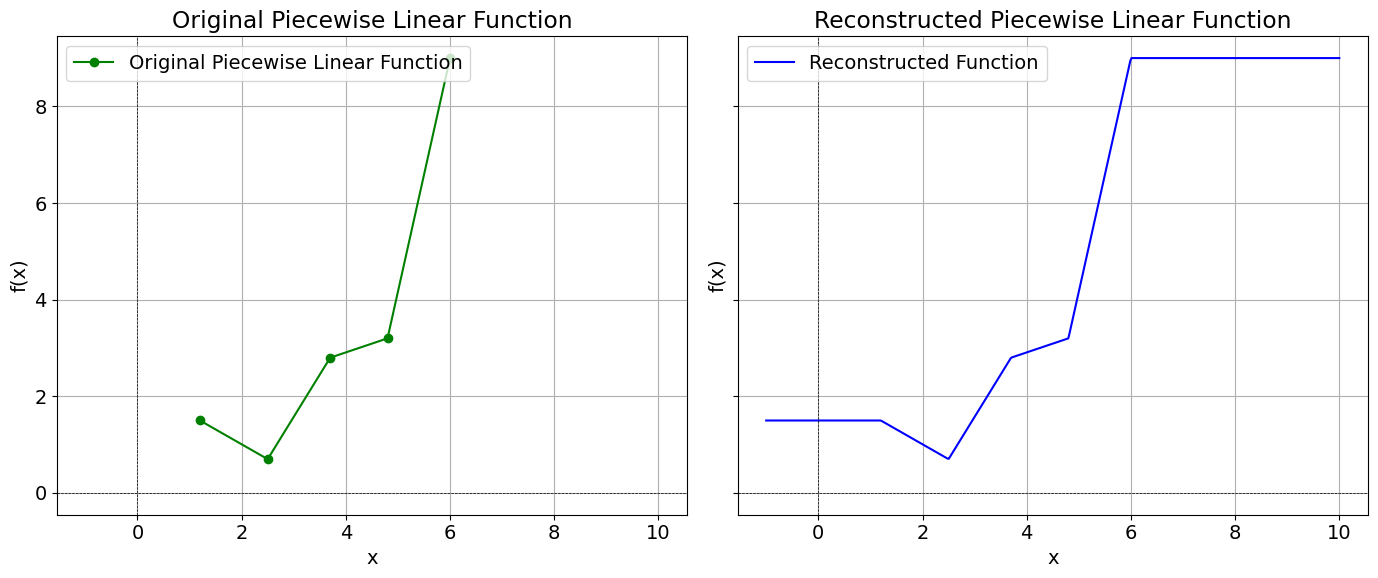

In [29]:
x = torch.linspace(-1, 10, 500)

# Compute the function output
with torch.no_grad():
    f_x = fixed_model(x)

# Visualize the results
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# Plot the original piecewise linear function by connecting the given x, y coordinates
axs[0].plot(x_points, y_points, label="Original Piecewise Linear Function", color="green", marker="o")
axs[0].set_title("Original Piecewise Linear Function")
axs[0].set_xlabel("x")
axs[0].set_ylabel("f(x)")
axs[0].axhline(0, color="black", linewidth=0.5, linestyle="--")
axs[0].axvline(0, color="black", linewidth=0.5, linestyle="--")
axs[0].legend(loc="upper left")
axs[0].grid()

# Plot the reconstructed piecewise linear function
axs[1].plot(x.numpy(), f_x.numpy(), label="Reconstructed Function", color="blue")
axs[1].set_title("Reconstructed Piecewise Linear Function")
axs[1].set_xlabel("x")
axs[1].set_ylabel("f(x)")
axs[1].axhline(0, color="black", linewidth=0.5, linestyle="--")
axs[1].axvline(0, color="black", linewidth=0.5, linestyle="--")
axs[1].legend(loc="upper left")
axs[1].grid()

plt.tight_layout()
plt.show()

The Fixed-Width ReLU Network demonstrates excellent approximation capabilities for piecewise linear functions, as shown in the visualization above.

### Extension to Higher Dimensions: 2D Function Approximation

Having demonstrated the capabilities of both `ReluSegmentNetwork` and `FixedWidthReluNetwork` for 1D piecewise linear approximation, we now explore a natural question: **Can these ReLU-based architectures effectively scale to
higher-dimensional problems?**

This extension is crucial for several reasons:
- Real-world applications often involve multidimensional functions
- The theoretical framework developed for 1D convex functions may not directly translate to higher dimensions
- Understanding the limitations in 2D helps motivate the need for alternative approaches (like Growing Axons)

We'll test this by approximating a smooth 2D function $f(x,y) = x^2y^2$ on the domain $[0, 1] \times [0, 1]$ using `ReluSegmentNetwork2D`. This function serves as an ideal test case because:
- It's smooth and convex in both variables
- It has varying curvature across the domain
- Its complexity increases multiplicatively with both inputs

#### Define the Target 2D Function

In [30]:
def target_function_2d(x, y):
    return x**2 * y**2

#### Define and Plot new Data Points

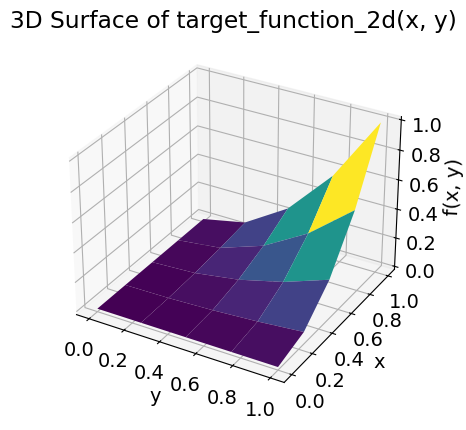

In [31]:
from mpl_toolkits.mplot3d import Axes3D

x_points = [0.0, 0.25, 0.5, 0.75, 1.0]
y_points = [0.0, 0.25, 0.5, 0.75, 1.0]

# Assume z_grid is already computed
z_grid = [
    [target_function_2d(torch.tensor(xi), torch.tensor(yj)).item() for yj in y_points]
    for xi in x_points
]

X, Y = np.meshgrid(y_points, x_points)
Z = np.array(z_grid)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('y')
ax.set_ylabel('x')
ax.set_zlabel('f(x, y)')
ax.set_title('3D Surface of target_function_2d(x, y)')

plt.show()


#### Initialize `ReluSegmentNetwork2D`

In [32]:
model = ReluSegmentNetwork2D(
    x_points=x_points, 
    y_points=y_points,
    z_grid=z_grid)

#### Evaluate and Compare `ReluSegmentNetwork2D` on 2D Grid
- Generate a uniform 2D grid over the range $[0, 1] \times [0, 1]$ using 100 points per axis.
- Flatten the meshgrid into coordinate vectors for batch evaluation.
- Compute predictions from the learned model `ReluSegmentNetwork2D(x, y)` and the ground truth `target_function_2d(x, y)` over the entire grid.
- Visualize and compare model accuracy against the true function across a 2D input space.

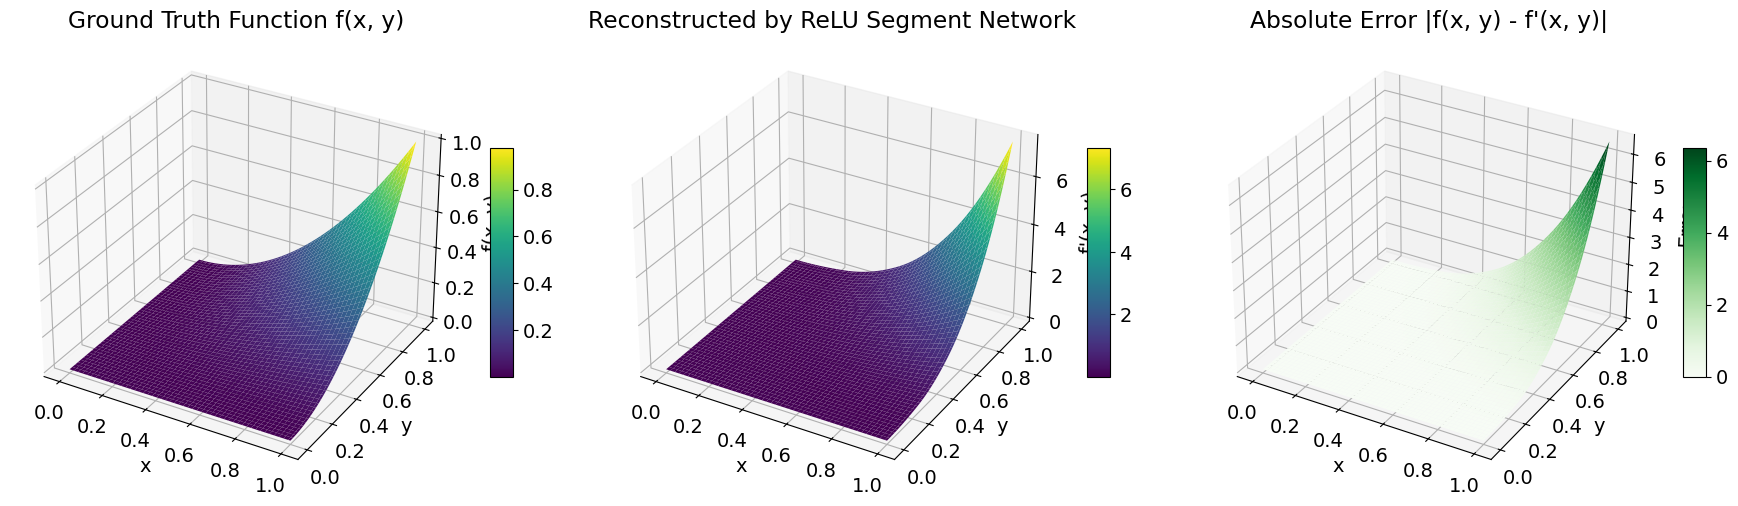

In [33]:
# Generate 1D arrays of 100 evenly spaced points between 0 and 1 for both x and y
test_x = torch.linspace(0, 1, 100)
test_y = torch.linspace(0, 1, 100)

# Create a 2D grid from test_x and test_y using matrix indexing
X, Y = torch.meshgrid(test_x, test_y, indexing='ij')

# Flatten the grid to pass as input to the model
x_flat = X.flatten()
y_flat = Y.flatten()

# Evaluate the model and the ground truth function without computing gradients
with torch.no_grad():
    pred_z = model(x_flat, y_flat)                  # model prediction using ReLU Segment network
    true_z = target_function_2d(x_flat, y_flat)     # ground truth values

# Reshape outputs back into 2D format for visualization
Z_true = true_z.reshape(100, 100)      # ground truth surface
Z_pred = pred_z.reshape(100, 100)      # predicted surface
Error = (Z_true - Z_pred).abs()        # absolute error between prediction and ground truth

# Create a figure with 3 subplots side by side
fig = plt.figure(figsize=(18, 5))

# 3D plot of Ground Truth
ax1 = fig.add_subplot(131, projection='3d')
surf1 = ax1.plot_surface(X.numpy(), Y.numpy(), Z_true.numpy(), cmap='viridis')
ax1.set_title("Ground Truth Function f(x, y)")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("f(x, y)")
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)

# 3D plot of Model Prediction
ax2 = fig.add_subplot(132, projection='3d')
surf2 = ax2.plot_surface(X.numpy(), Y.numpy(), Z_pred.numpy(), cmap='viridis')
ax2.set_title("Reconstructed by ReLU Segment Network")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("f'(x, y)")
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)

# 3D plot of Absolute Error
ax3 = fig.add_subplot(133, projection='3d')
surf3 = ax3.plot_surface(X.numpy(), Y.numpy(), Error.numpy(), cmap='Greens')
ax3.set_title("Absolute Error |f(x, y) - f'(x, y)|")
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_zlabel("Error")
fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=10)

plt.tight_layout()
plt.show()

On a **100 × 100 evaluation grid**:

- The **ground truth** is a smooth, inclined plane.
- The **reconstructed surface** from the ReLU network shows **erratic, nonlinear behavior**, especially in regions where both $x$ and $y$ are large.
- The **error plot** highlights **major deviations** near $(x = 1, y = 1)$, with **errors exceeding 25 units**.

To avoid these limitations, we will try to apply an alternative method called **Growing Axons** in Chapter 5 of this project. Let’s see whether it gives better approximation performance; this promises to be a particularly exciting section!

## Chapter 4: Algorithms and Analysis
In the proof of **Theorem 1**, it is shown that the approximation error $\Delta(f_n)$ can always be reduced by adjusting the segment with the largest error, unless all segments share equal error.  

However, this process may require infinite number of iterations to converge, as low-error segments remain fixed.  
To address this, we reproduce the improved algorithm which updates all segments simultaneously at each step.  

We introduce functions and utilities as needed during the explanation of each algorithm.

### Function Definitions
We define three convex functions of increasing complexity, which are $f(x)=x^2$, $f(x)=x^3$, $f(x)=e^x$, to investigate how the approximation algorithm performs under different curvature profiles. These functions represent typical test cases for evaluating the algorithms.

In [34]:
def square(x):
    return x**2

def triplet(x):
    return x**3

def exp(x):
    return np.exp(x)

I choose $n \in \{2, 3, 5, 10\}$ as the number of segments to illustrate how the approximation improves with finer partitions. The step size is set small enough to ensure precise adjustments during the optimization.

In [35]:
n = [2, 3, 5, 10]
step = 2e-5

Below is the function to calculate the mean error.

In [36]:
def mean_err(errs):
    return sum(errs) / len(errs)

### Start approximating variables
We now begin implementing the algorithm to the selected functions using increasing values of $n$. Key results such as approximation errors, theoretical bounds, and optimization rounds are computed and summarized in the table below.

To support traceability, progress bars are shown during execution to indicate the algorithm’s progress under each configuration.

In [37]:
errs = []

In [38]:
run_optimal_approximation(n, exp, "exp(x)", a, b, step, errs, get_derivative, mean_err, max_fx, min_fx)

Optimal Approximation: exp(x):   0%|          | 0/4 [00:00<?, ?it/s]

n = 2
f(x) = exp(x)


Optimal Approximation: exp(x):  25%|██▌       | 1/4 [00:03<00:11,  3.71s/it]

--------------------------------------------------
n = 3
f(x) = exp(x)


Optimal Approximation: exp(x):  50%|█████     | 2/4 [00:09<00:10,  5.19s/it]

--------------------------------------------------
n = 5
f(x) = exp(x)


Optimal Approximation: exp(x):  75%|███████▌  | 3/4 [00:20<00:07,  7.66s/it]

--------------------------------------------------
n = 10
f(x) = exp(x)


Optimal Approximation: exp(x): 100%|██████████| 4/4 [00:33<00:00,  8.36s/it]

--------------------------------------------------


In [39]:
run_optimal_approximation(n, square, "x^2", a, b, step, errs, get_derivative, mean_err, max_fx, min_fx)

Optimal Approximation: x^2: 100%|██████████| 4/4 [00:00<00:00, 444.54it/s]

n = 2
f(x) = x^2
--------------------------------------------------
n = 3
f(x) = x^2
--------------------------------------------------
n = 5
f(x) = x^2
--------------------------------------------------
n = 10
f(x) = x^2
--------------------------------------------------


In [40]:
run_optimal_approximation(n, triplet, "x^3", a, b, step, errs, get_derivative, mean_err, max_fx, min_fx)

Optimal Approximation: x^3:   0%|          | 0/4 [00:00<?, ?it/s]

n = 2
f(x) = x^3


Optimal Approximation: x^3:  25%|██▌       | 1/4 [00:05<00:17,  5.80s/it]

--------------------------------------------------
n = 3
f(x) = x^3


Optimal Approximation: x^3:  50%|█████     | 2/4 [00:16<00:17,  8.76s/it]

--------------------------------------------------
n = 5
f(x) = x^3


Optimal Approximation: x^3:  75%|███████▌  | 3/4 [00:36<00:13, 13.76s/it]

--------------------------------------------------
n = 10
f(x) = x^3


Optimal Approximation: x^3: 100%|██████████| 4/4 [00:59<00:00, 14.78s/it]

--------------------------------------------------


### Results

The results are displayed in the form of the table below:

In [41]:
df = pd.DataFrame(errs)
df

,function,n,mean_err,upper_bound,lower_bound,max_gap,rounds
0,exp(x),2,0.026349,0.042445,1.562292e-02,0.000003,3089
1,exp(x),3,0.011699,0.018865,6.943520e-03,0.000004,5544
2,exp(x),5,0.004210,0.006791,2.499667e-03,0.000006,10054
3,exp(x),10,0.001055,0.001698,6.249168e-04,0.000319,13138
4,x^2,2,0.031250,0.031253,3.124985e-02,0.000000,0
5,x^2,3,0.013889,0.013890,1.388882e-02,0.000003,2
6,x^2,5,0.005000,0.005000,4.999976e-03,0.000004,4
7,x^2,10,0.001250,0.001250,1.249994e-03,0.000002,9
8,x^3,2,0.044863,0.093750,6.525807e-07,0.000006,5775
9,x^3,3,0.019462,0.041667,2.900359e-07,0.000008,11183


 We can see that the values on the above table are really close to published ones in the paper:

 - For all tested functions, the mean approximation error (`mean_err`) decreases as the number of linear segments (`n`) increases. This trend aligns with the theoretical understanding that a finer partition allows for a closer fit to the target convex function.
 - Across all configurations, the mean approximation error (`mean_err`) lies between the computed upper and lower bounds, confirming the theoretical validity and tightness of these estimates.
 - The number of optimization rounds required (`rounds`) reflects the difficulty of balancing approximation errors across segments. Functions with simple, symmetric curvature like $f(x)=x^2$ converge quickly, while more complex or asymmetric functions such as $f(x)=x^3$ and $f(x)=e^x$ require significantly more rounds due to greater variation in local curvature and error distribution.

## Chapter 5: Growing Axons - A Greedy Alternative for Function Approximation

#### Traditional ReLU Networks

Traditional ReLU neural networks follow a standard feed-forward architecture with sequential layer-to-layer connections. The theoretical framework developed by Bo Liu and Yi Liang focuses specifically on optimal approximations of strict convex univariate functions, where the second-order derivatives are positive $f''(x) > 0$. These networks can be designed with either fixed-depth or fixed-width architectures, with the key insight that optimal approximations require all linear segments to have equal approximation errors.

This approach provides exact theoretical bounds with a convergence rate of $\mathcal{O}(1/n^{2})$ for $n$ linear pieces, establishing both necessary and sufficient conditions for optimality. However, despite these strong theoretical foundations, practical implementation using Stochastics Gradient Descent (SGD) or Adaptive Moment Estimation (ADAM) with random initialization consistently fails to achieve the theoretical bounds.

To address this issue, we will consider a new architecture, Axon Architecture, as described below.

#### Axon Architecture

The Axon architecture represents a paradigm shift, incorporating dense connections with skip connections and orthogonalization procedures. Inspired by compressed sensing and Orthogonal Matching Pursuit (OMP) principles, this approach grows the network incrementally by adding one neuron each time. Each new basis function is generated as a non-linear activation function applied to a linear combination of previous basis functions.

The key innovation lies in the greedy sequential optimization strategy, where each new neuron is selected to minimize the angle between the new basis function and the current residual. This approach includes structured initialization based on input dimensions and maintains orthogonality through Gram-Schmidt procedures.

**Now, we compare the performance of both methods on convex and non-convex functions through specific experiments to gain a deeper understanding.**

### Performance on Convex Functions

#### Theoretical Capabilities
For convex functions, traditional ReLU networks provide comprehensive theoretical coverage with proven optimal approximation bounds. The framework establishes that for functions with constant second-order derivatives, the optimal approximation error can be computed exactly, and both upper and lower bounds are derived for general convex functions.

The Axon approach, while lacking theoretical guarantees, demonstrates empirically that it can achieve near-optimal results through its greedy construction. The method consistently outperforms traditional SGD/ADAM optimization on the same architectural complexity.

#### Experimental Evidence

##### Function: $f(x)=x^{2}$

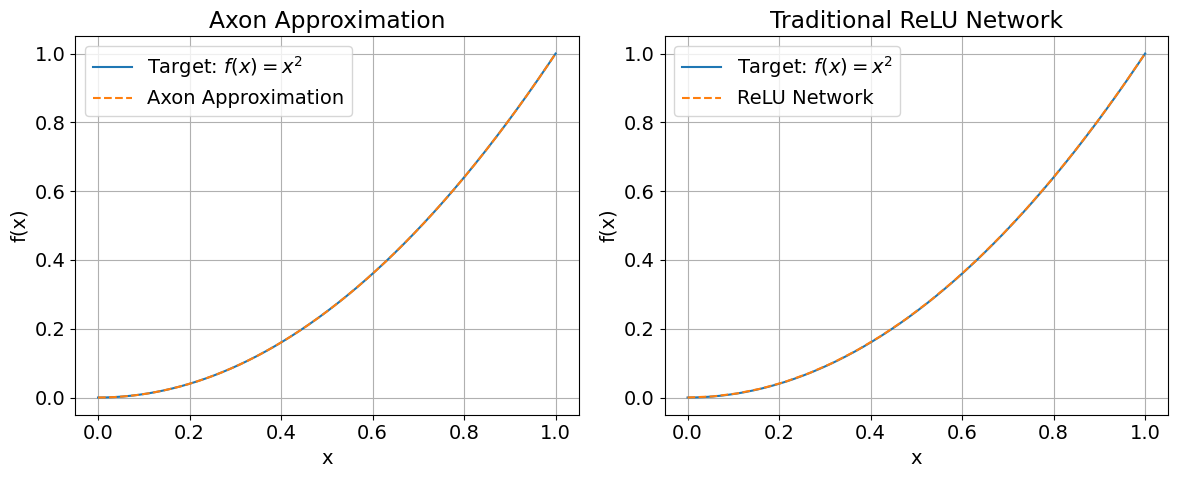

Computing errors for x²...


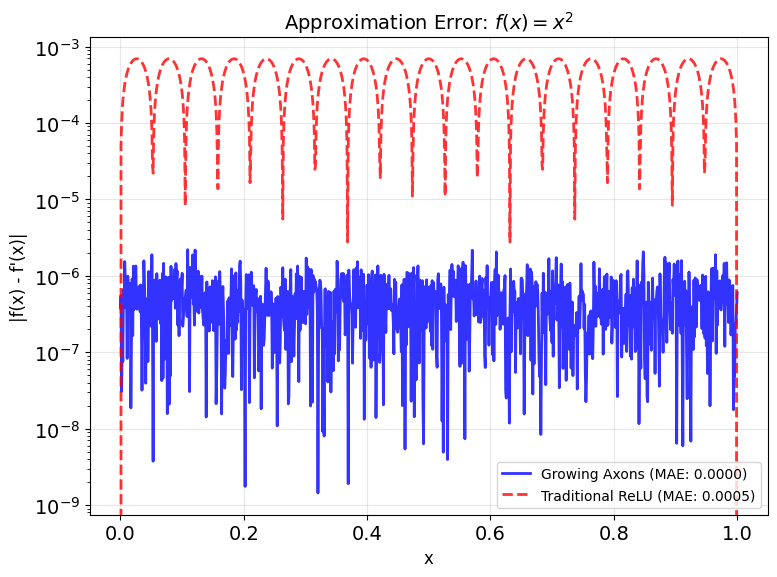

In [42]:
target_function = lambda x: x**2

xs, ys, approx_axon, approx_relu = compute_approximations(
    target_function=target_function
)

plot_approximations(
    xs, ys, approx_axon, approx_relu, func_label="\\mathit{f}(x) = x^2",
)

result = analyze_and_plot_errors(
    target_function=target_function,
    function_name="x²",
    latex_name="x^2",
    xs = xs,
    ys=ys,
    approx_axon=approx_axon,
    approx_relu=approx_relu
)

Both methods reconstruct the curve very well, essentially overlapping the target function. 

Visually, there is no noticeable difference between the two approaches, indicating that for a simple convex polynomial like $f(x)=x^{2}$, both achieve the optimal approximation.

##### Function: $f(x)=-\ln(x+\varepsilon)$, $\varepsilon$ is a very small constant (e.g., $\varepsilon = 10 ^{-6}$ ).

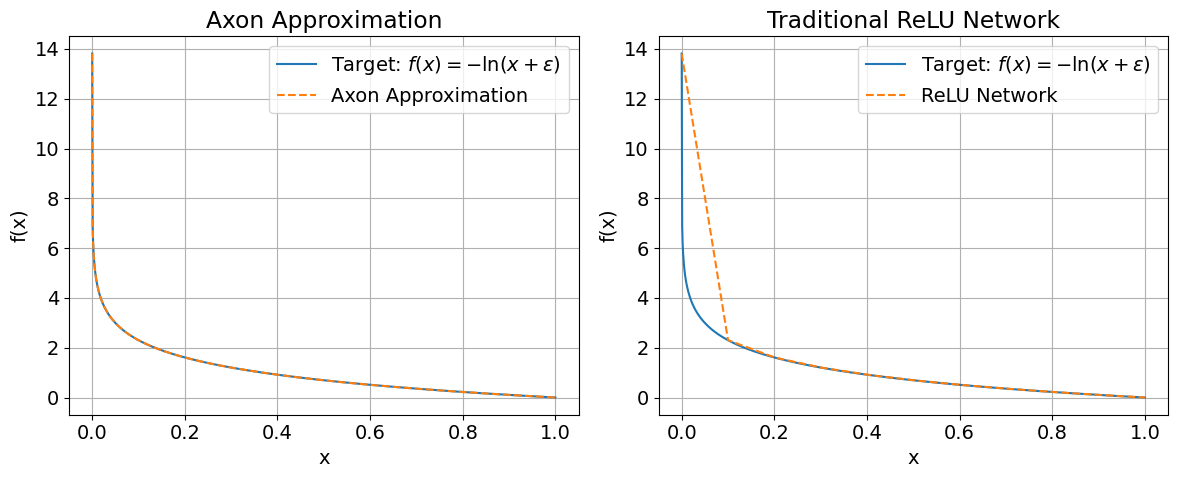

Computing errors for -log(x + eps)...


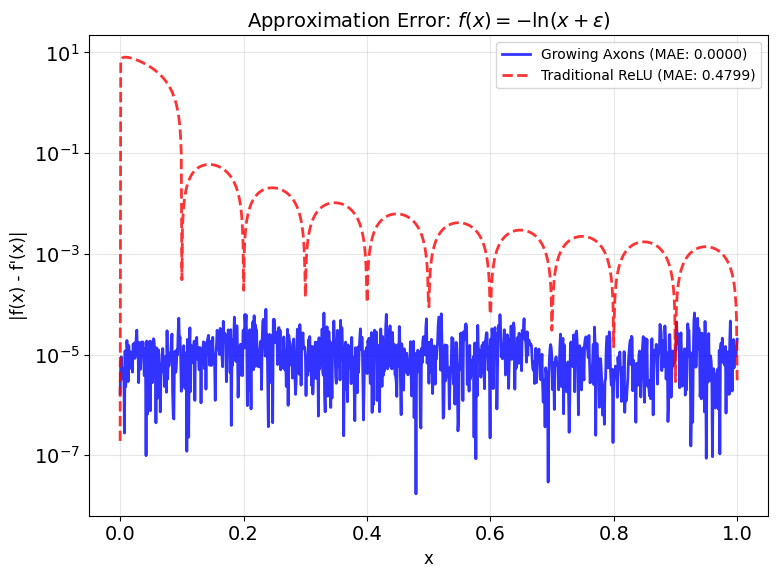

In [43]:
eps = 1e-6
target_function = lambda x: -np.log(x + eps)

xs, ys, approx_axon, approx_relu = compute_approximations(
    target_function=target_function,
    domain=(0, 1),
    num_samples=1000,
    relu_range=(0, 1),
    relu_num_points=11,
    axon_K=100
)

plot_approximations(xs, ys, approx_axon, approx_relu, func_label="\\mathit{f}(x) = -\\ln(x+ \\varepsilon)")
result = analyze_and_plot_errors(
    target_function=target_function,
    function_name="-log(x + eps)",
    latex_name="-\\ln(x + \\varepsilon)",
    xs = xs,
    ys=ys,
    approx_axon=approx_axon,
    approx_relu=approx_relu
)

- The Axon approximation follows the target curve closely even near $x = 0$.

- The traditional ReLU network underestimates $f(x)$ in the region $0 < x < 0.1$, producing a visible gap at the start before converging later.

In this case, for functions with high curvature near the boundary, it is clear that Axon approximates more accurately than traditional ReLU.

##### Function: $f(x) = e^{-x}$

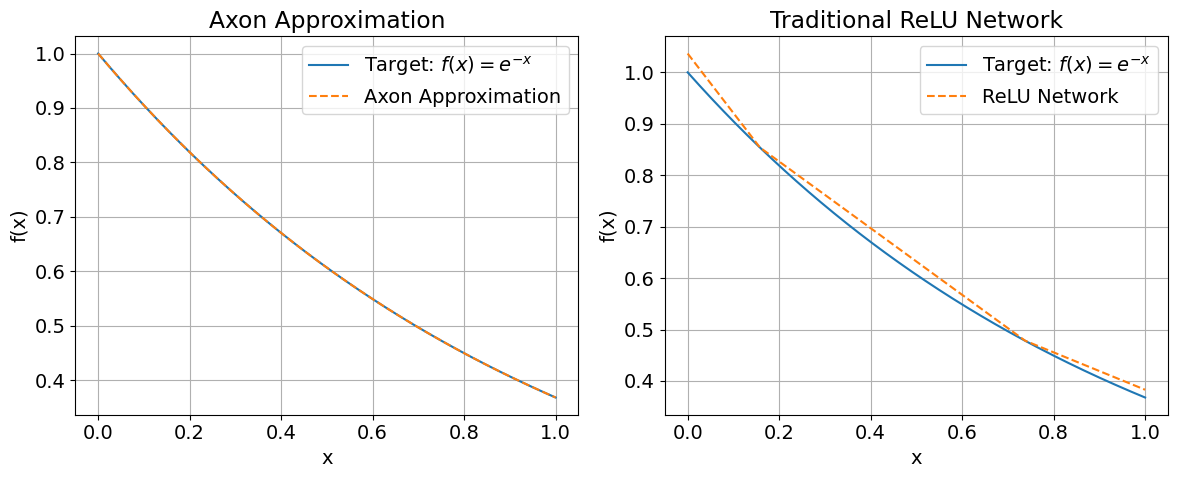

Computing errors for exp(-x)...


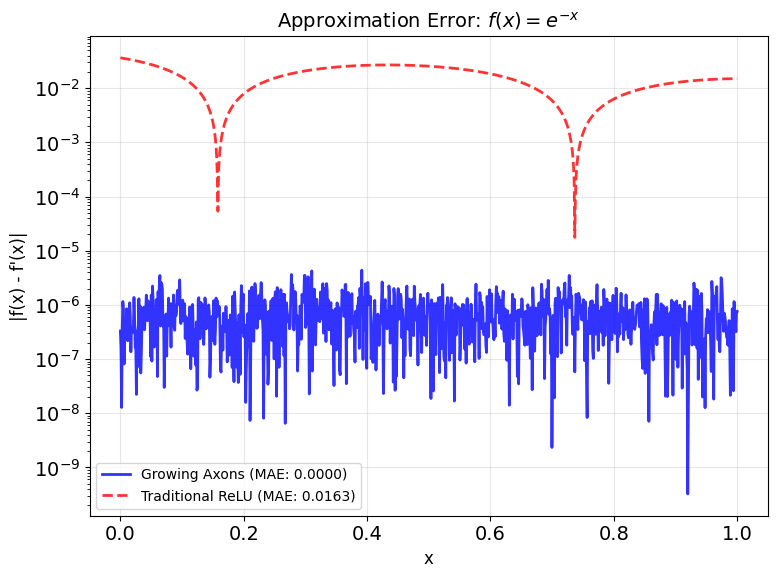

In [44]:
target_function = lambda x: np.exp(-x)

xs, ys, approx_axon, approx_relu = compute_approximations(
    target_function=target_function,
    domain=(0, 1),
    relu_range=(-1, 10),
    relu_num_points=20,
    axon_K=100
)

plot_approximations(xs, ys, approx_axon, approx_relu, func_label="\\mathit{f}(x) = e^{-x}")

result = analyze_and_plot_errors(
    target_function=target_function,
    function_name="exp(-x)",
    latex_name="e^{-x}",
    xs = xs,
    ys=ys,
    approx_axon=approx_axon,
    approx_relu=approx_relu
)


- Once again, the Axon method accurately follows the curve, virtually overlapping the target function across the entire domain.

- The traditional ReLU network tends to overestimate $f(x)$ across most of the domain.

This shows that for functions with continuously varying curvature, the Axon approach still remains more stable and precise than a traditional ReLU one.

### Performance on Non-Convex Functions

While the traditional ReLU approach was developed specifically for convex functions with theoretical guarantees, real-world applications often involve non-convex functions where these guarantees no longer apply. This is where the     
Growing Axons method truly shines.

#### Axon's Adaptability
The Growing Axons architecture demonstrates remarkable flexibility:
- **No Convexity Assumptions**: The greedy construction adapts to any function complexity
- **Local Feature Detection**: Can capture oscillations, discontinuities, and other non-convex features
- **Consistent Methodology**: The same algorithm works for both convex and non-convex cases

Let's test this adaptability on a highly challenging non-convex function:

#### Theoretical Limitations
The traditional ReLU approach shows significant limitations when extended beyond convex functions. The theoretical framework breaks down completely for non-convex cases, providing no optimality guarantees or convergence bounds. The necessary and sufficient conditions for optimal approximation rely fundamentally on convexity properties.

#### Axon's Adaptability
The Axon architecture demonstrates remarkable flexibility in handling non-convex functions without requiring modifications to its core methodology. The greedy approach adapts naturally to function complexity, making no assumptions about convexity.

**We will understand these more clearly through the following example.**

#### Highly Oscillatory Functions $f(x) = sin(20x)$

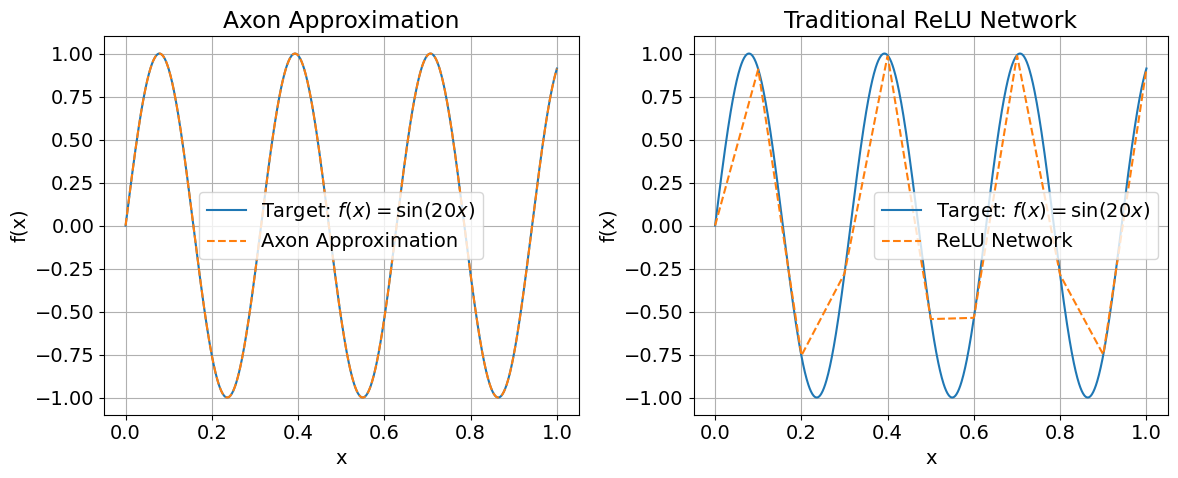

Computing errors for sin(20x)...


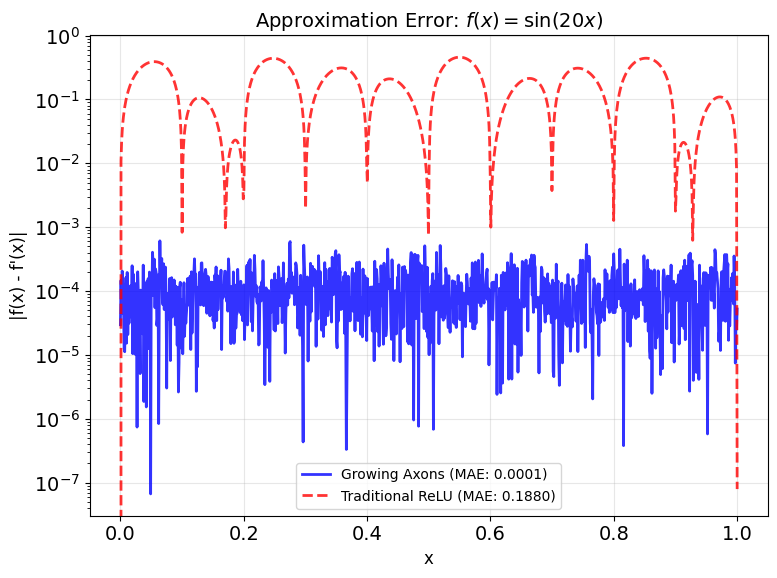

In [45]:
target_function = lambda x: np.sin(20 * x)

xs, ys, approx_axon, approx_relu = compute_approximations(
    target_function=target_function,
    domain=(0, 1),
    relu_range=(0, 1),
    relu_num_points=11,
    axon_K=100
)

plot_approximations(xs, ys, approx_axon, approx_relu, func_label="\\mathit{f}(x) = \\sin(20x)")

result = analyze_and_plot_errors(
    target_function=target_function,
    function_name="sin(20x)",
    latex_name="\\sin(20x)",
    xs = xs,
    ys=ys,
    approx_axon=approx_axon,
    approx_relu=approx_relu
)

- The Axon approach closely reproduces the high‐frequency sine wave, with peaks, troughs, and zero‐crossings virtually overlapping the target. Errors are very tiny, showing no visible phase shift.

- The traditional ReLU produces significant phase shifts - failing to track the sine waves.

### Optimization Strategy Comparison

#### Traditional Approach Challenges
The traditional ReLU approach suffers from a significant gap between theoretical potential and practical implementation. Despite having provable optimal constructions, standard optimization methods fail to discover these solutions. The simultaneous optimization of all parameters creates a highly non-convex landscape that gradient-based methods struggle to navigate effectively.

#### Axon's Outstanding Feature
The Axon method's sequential construction provides several advantages:

+ Each optimization substep involves a simpler, lower-dimensional problem

+ The orthogonalization procedure ensures basis functions remain independent

+ The greedy selection criterion provides a principled way to improve approximation at each step

+ Structured initialization eliminates poor random starting points

### Summary
The comparison reveals complementary strengths between traditional and Axon-style architectures. Traditional ReLU networks provide essential theoretical insights and optimal bounds for convex functions but struggle with practical optimization. The Axon architecture sacrifices theoretical guarantees for superior practical performance across both convex and non-convex functions.

For convex functions, both approaches can achieve good results, but Axon provides more reliable optimization. For non-convex functions, the Axon approach represents a clear advancement, handling cases where traditional methods fail entirely. The choice between approaches should be guided by whether theoretical guarantees or practical performance takes priority in the specific application context.

#### Use Growing Axons to Approximate 2D Functions

With the excellent performance that Axon has delivered in 1D, the we now apply the Axon method to the 2D approximation problem to see if it maintains its high performance. As mentioned in Chapter 3, we revisit the target function:
$$
f(x,y)= x^2y^2
$$

In [46]:
def f(xs):
    return (xs[:,0]**2 * xs[:,1]**2).astype(np.float64)

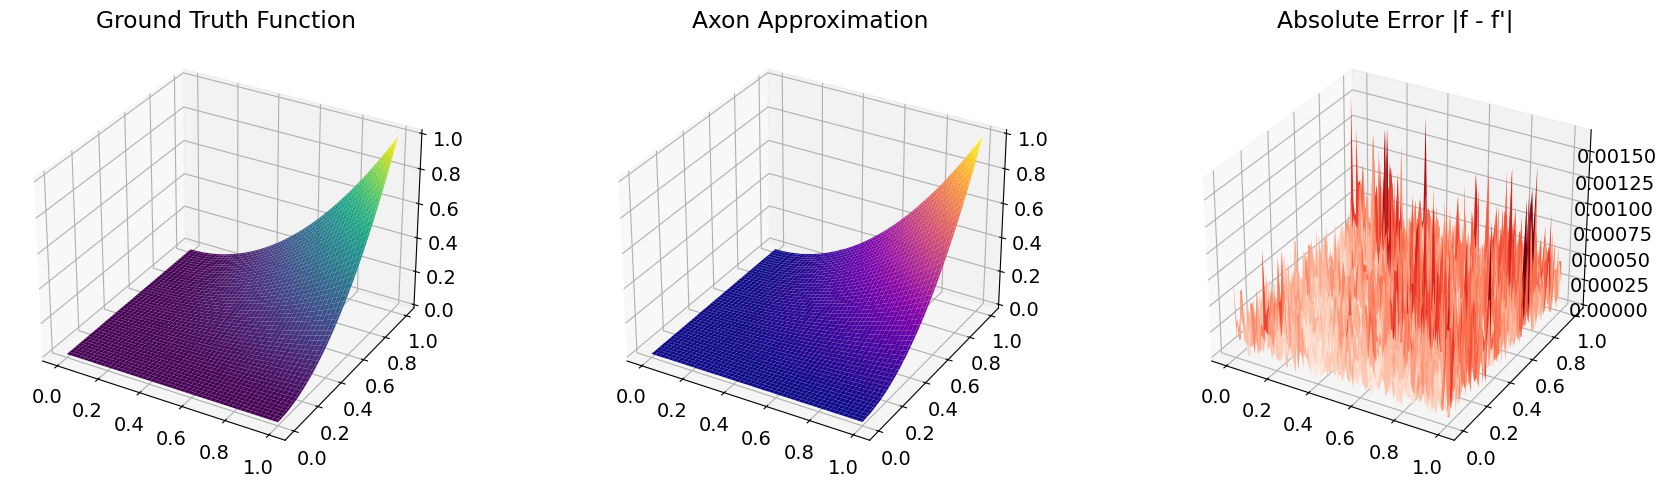

In [47]:
x = np.linspace(0, 1, 100)
xx, yy = np.meshgrid(x, x)
xs = np.hstack([xx.flatten()[:, np.newaxis], yy.flatten()[:, np.newaxis]])
ys = f(xs)

# axon_algorithm is already defined
bs_2d, bs_coefs, r, coefs, norms, errs_2d = axon_algorithm(xs, ys, 100, new_obj=False)

# Calculate approximation
approx_axon_2d = bs_2d @ (bs_2d.T @ ys)

Z_true = ys.reshape(100, 100)
Z_approx = approx_axon_2d.reshape(100, 100)
Z_error = np.abs(Z_true - Z_approx)

# Plot
fig = plt.figure(figsize=(18, 5))

# Ground truth
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.plot_surface(xx, yy, Z_true, cmap='viridis')
ax1.set_title("Ground Truth Function")

# Axon approximation
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.plot_surface(xx, yy, Z_approx, cmap='plasma')
ax2.set_title("Axon Approximation")

# Error surface
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.plot_surface(xx, yy, Z_error, cmap='Reds')
ax3.set_title("Absolute Error |f - f'|")

plt.tight_layout()
plt.show()

The Axon approach accurately approximates the 2D function with low absolute error. The reconstructed surface closely matches the ground truth, showing strong generalization even in two dimensions. Small error spikes are present but overall performance is still impressive.

## Conclusion

In this study, we addressed the problem of optimally approximating a convex function $f(x)$ using a limited number $n$ of linear segments. We established both necessary and sufficient conditions for optimality and demonstrated its uniqueness. By deriving lower and upper bounds, we showed that the approximation error decreases at a rate of $\mathcal{O}(1/n^{2})$. Furthermore, we introduced ReLU network architectures with fixed depth and width that can construct these optimal linear approximations. Then, we proposed a practical algorithm for finding such approximations, proved its convergence, and validated its performance through experimental results. Lastly, we introduced the Growing Axons as an alternative "greedy" construction, and we showed that this method can be more effective for learning neural network architectures than traditional deep learning approaches, whose theoretical performance is often challenging to verify in practice.


## References

[1] Bo Liu, Yi Liang (2021). *Optimal function approximation with ReLU neural networks*, Neurocomputing, Volume 435.

[2] Fokina, Daria and Oseledets, Ivan. (2023). Growing axons: greedy learning of neural networks with application to function approximation. Russian Journal of Numerical Analysis and Mathematical Modelling. 38. 1-12.10.1515/rnam-2023-0001.

[3] Implementation of Axon algorithm for function approximation: https://github.com/dashafok/axon-approximation

[4] Boris Hanin, David Rolnick (2019). Complexity of Linear Regions in Deep Networks.

[5] Dmitry Yarotsky (2017). Error bounds for approximations with deep ReLU networks.